## Covid-19 Data Modelling and Analysis

In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [97]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [98]:
init_notebook_mode(connected=True)

In [99]:
import cufflinks as cf
cf.go_offline()

In [100]:
df = pd.read_csv('https://api.covid19india.org/csv/latest/case_time_series.csv')

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date             197 non-null    object
 1   Daily Confirmed  197 non-null    int64 
 2   Total Confirmed  197 non-null    int64 
 3   Daily Recovered  197 non-null    int64 
 4   Total Recovered  197 non-null    int64 
 5   Daily Deceased   197 non-null    int64 
 6   Total Deceased   197 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 10.9+ KB


In [102]:
df.columns

Index(['Date', 'Daily Confirmed', 'Total Confirmed', 'Daily Recovered',
       'Total Recovered', 'Daily Deceased', 'Total Deceased'],
      dtype='object')

In [103]:
df['Date_time'] = df['Date'].apply(lambda dt : dt + ' 2020')
df['Date_time'] = pd.to_datetime(df['Date_time'])
df['Daily Active'] = df['Daily Confirmed'] - df['Daily Deceased'] - df['Daily Recovered']
df['Total Active'] = df['Total Confirmed'] - df['Total Deceased'] - df['Total Recovered']
df = df[['Date','Date_time', 'Daily Confirmed', 'Total Confirmed','Daily Active', 'Total Active','Daily Recovered',
       'Total Recovered', 'Daily Deceased', 'Total Deceased']]

In [104]:
df

,Date,Date_time,Daily Confirmed,Total Confirmed,Daily Active,Total Active,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
0,30 January,2020-01-30,1,1,1,1,0,0,0,0
1,31 January,2020-01-31,0,1,0,1,0,0,0,0
2,01 February,2020-02-01,0,1,0,1,0,0,0,0
3,02 February,2020-02-02,1,2,1,2,0,0,0,0
4,03 February,2020-02-03,1,3,1,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
192,09 August,2020-08-09,62117,2214151,6630,635402,54474,1534271,1013,44478
193,10 August,2020-08-10,53016,2267167,4767,640169,47362,1581633,887,45365
194,11 August,2020-08-11,61252,2328419,3956,644125,56461,1638094,835,46200
195,12 August,2020-08-12,67066,2395485,8357,652482,57759,1695853,950,47150


In [105]:
print(f'Date : {df.iloc[df.shape[0]-1][0]}\n\n')

# daily
print(f'Daily Confirmed : {df.iloc[df.shape[0]-1][2]}')
print(f'Daily Active    : {df.iloc[df.shape[0]-1][4]}')
print(f'Daily Recovered : {df.iloc[df.shape[0]-1][6]}')
print(f'Daily Deceased  : {df.iloc[df.shape[0]-1][8]}')

print('\n')

# total
print(f'Total Confirmed : {df.iloc[df.shape[0]-1][3]}')
print(f'Total Active    : {df.iloc[df.shape[0]-1][5]}')
print(f'Total Recovered : {df.iloc[df.shape[0]-1][7]}')
print(f'Total Deceased  : {df.iloc[df.shape[0]-1][9]}')

Date : 13 August 


Daily Confirmed : 64142
Daily Active    : 8360
Daily Recovered : 54776
Daily Deceased  : 1006


Total Confirmed : 2459627
Total Active    : 660842
Total Recovered : 1750629
Total Deceased  : 48156


In [11]:
df[['Date','Total Confirmed','Total Active', 'Total Recovered', 'Total Deceased']].iplot(x='Date',xaxis_tickangle=315)

In [12]:
df[['Date','Daily Confirmed','Daily Active', 'Daily Recovered', 'Daily Deceased']].iplot(x='Date',xaxis_tickangle=315)

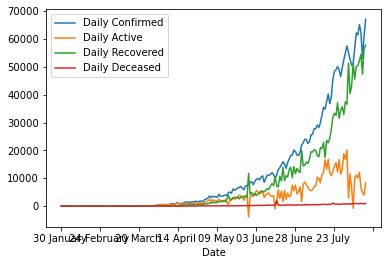

In [52]:
df[['Date','Daily Confirmed','Daily Active', 'Daily Recovered', 'Daily Deceased']].plot(x='Date')

## Basics of model - SIR Model

### Susceptible to Infected

In [13]:
# effective contact rate (no. of people met * risk of infection)
5 * 0.25

1.25

In [14]:
4*0.10

0.4

### Infected to Removed

In [15]:
# recovery period (hom long does it take to recover)
1 / 14

0.07142857142857142

In [16]:
# removal rate
664 * (1/14)

47.42857142857142

### R0 (reproduction number)

In [17]:
# r0 = effective contact rate / recovery period
1 / (1/14)

14.0

## Modelling

In [18]:
from scipy.integrate import odeint
from datetime import datetime, timedelta

# The SIR model differential equations.
def deriv(state, t, N, beta, gamma):
    S, I, R = state
    # Change in S population over time
    dSdt = -beta * S * I / N
    # Change in I population over time
    dIdt = beta * S * I / N - gamma * I
    # Change in R population over time
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


effective_contact_rate = 0.1076
recovery_rate = 1/14

# We'll compute this for fun
print("R0 is", effective_contact_rate / recovery_rate)

total_pop = 14700000
recovered = 200
infected = 1000
susceptible = total_pop - infected - recovered

# A list of days, 0-160
days = range(0, 179 + df.shape[0]-1)

# Use differential equations to predict spread of the virus
ret = odeint(deriv,
             [susceptible, infected, recovered],
             days,
             args=(total_pop, effective_contact_rate, recovery_rate))
S, I, R = ret.T

# Build a dataframe of predicted values
df_new = pd.DataFrame({
    'suseptible': S,
    'infected': I,
    'recovered': R,
    'day': days
})


l = []
for i in range(1,179):
    l.append(df['Date_time'][df.shape[0]-1] + timedelta(days=i))

old = df['Date_time'].to_list()

final = np.array(old+l)


df_new['Date_Time'] = final
df_final = pd.concat([df_new,df],axis=1)

df_final.set_index('Date_Time')[['suseptible', 'infected', 'recovered','Total Active', 'Total Recovered',
       'Total Deceased']].iplot()

R0 is 1.5064000000000002


In [95]:
df_final

,suseptible,infected,recovered,day,Date_Time,Date,Date_time,Daily Confirmed,Total Confirmed,Daily Active,Total Active,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
0,1.469880e+07,1000.000000,2.000000e+02,0,2020-01-30,30 January,2020-01-30,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1.469869e+07,1036.824055,2.727358e+02,1,2020-01-31,31 January,2020-01-31,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.469858e+07,1075.003242,3.481500e+02,2,2020-02-01,01 February,2020-02-01,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.469846e+07,1114.587366,4.263411e+02,3,2020-02-02,02 February,2020-02-02,1.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0
4,1.469834e+07,1155.628054,5.074114e+02,4,2020-02-03,03 February,2020-02-03,1.0,3.0,1.0,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,6.199460e+06,75908.101297,8.424632e+06,369,2021-02-02,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
370,6.196060e+06,73955.288674,8.429984e+06,370,2021-02-03,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
371,6.192751e+06,72050.944830,8.435199e+06,371,2021-02-04,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
372,6.189528e+06,70193.959462,8.440278e+06,372,2021-02-05,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Statewise and Districtwise

In [23]:
df_state = pd.read_csv('https://api.covid19india.org/csv/latest/state_wise.csv')
df_state = df_state[['State', 'Confirmed', 'Recovered', 'Deaths', 'Active',
       'Last_Updated_Time']]

In [27]:
df_state.sort_values('Confirmed',ascending=False)

,State,Confirmed,Recovered,Deaths,Active,Last_Updated_Time
0,Total,2400418,1698038,47176,654730,13/08/2020 13:17:41
1,Maharashtra,548313,381843,18650,147513,12/08/2020 22:49:36
2,Tamil Nadu,314520,256313,5278,52929,12/08/2020 18:52:40
3,Andhra Pradesh,254146,161425,2296,90425,12/08/2020 18:36:44
4,Karnataka,196494,112633,3511,80341,12/08/2020 20:04:38
5,Delhi,148504,133405,4153,10946,12/08/2020 16:08:37
6,Uttar Pradesh,136238,84661,2230,49347,12/08/2020 18:36:47
7,West Bengal,104326,76120,2203,26003,12/08/2020 21:39:49
8,Bihar,90553,60068,474,30010,12/08/2020 18:36:51
9,Telangana,86475,63074,665,22736,13/08/2020 09:54:39


In [25]:
df_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   State              38 non-null     object
 1   Confirmed          38 non-null     int64 
 2   Recovered          38 non-null     int64 
 3   Deaths             38 non-null     int64 
 4   Active             38 non-null     int64 
 5   Last_Updated_Time  38 non-null     object
dtypes: int64(4), object(2)
memory usage: 1.9+ KB


In [42]:
df_district = pd.read_csv('https://api.covid19india.org/csv/latest/district_wise.csv')
df_district = df_district[['State', 'District', 'Confirmed',
       'Active', 'Recovered', 'Deceased', 'Last_Updated' ]]

In [43]:
df_district

,State,District,Confirmed,Active,Recovered,Deceased,Last_Updated
0,State Unassigned,Unassigned,0,0,0,0,NaN
1,Andaman and Nicobar Islands,Nicobars,0,0,0,0,NaN
2,Andaman and Nicobar Islands,North and Middle Andaman,1,0,1,0,NaN
3,Andaman and Nicobar Islands,South Andaman,51,19,32,0,NaN
4,Andhra Pradesh,Foreign Evacuees,434,0,434,0,NaN
...,...,...,...,...,...,...,...
795,Telangana,Unknown,457,-62701,62523,635,NaN
796,Tripura,Unknown,0,0,0,0,NaN
797,Uttar Pradesh,Unknown,0,0,0,0,NaN
798,Uttarakhand,Unknown,0,0,0,0,NaN


In [44]:
df_district[df_district['State']=='Rajasthan'].sort_values('Confirmed',ascending=False)

,State,District,Confirmed,Active,Recovered,Deceased,Last_Updated
552,Rajasthan,Jodhpur,8414,1636,6691,87,NaN
547,Rajasthan,Jaipur,6880,2049,4608,223,NaN
529,Rajasthan,Alwar,5531,1990,3518,23,NaN
557,Rajasthan,Pali,3292,433,2824,35,NaN
554,Rajasthan,Kota,3251,1667,1531,53,NaN
533,Rajasthan,Bharatpur,3054,434,2560,60,NaN
535,Rajasthan,Bikaner,2865,690,2126,49,NaN
528,Rajasthan,Ajmer,2748,506,2187,55,NaN
532,Rajasthan,Barmer,1854,351,1489,14,NaN
555,Rajasthan,Nagaur,1809,249,1525,35,NaN


In [45]:
import streamlit as st

In [ ]:
st.sidebar.video()

In [ ]:
st.sidebar.image()

In [ ]:
st.sidebar.button()

In [ ]:
st.success()

In [ ]:
st.selectbox()

# helpline number state-wise

In [58]:
df_helpline = pd.DataFrame(helpline)

In [60]:
df_helpline.to_csv('helpline.csv',index=False)

In [71]:
df_helpline.head(20)

,State,Helpline
0,Central,+91-11-23978046
1,Maharashtra,020-26127394
2,Tamil Nadu,044-29510500
3,Andhra Pradesh,0866-2410978
4,Karnataka,104
5,Delhi,011-22307145
6,Uttar Pradesh,18001805145
7,West Bengal,"1800313444222, 03323412600"
8,Bihar,104
9,Telangana,104


In [70]:
df_helpline[df_helpline['State']=='Central']['Helpline'].values[0]

'+91-11-23978046'

In [73]:
from datetime import date

TypeError: descriptor 'ctime' requires a 'datetime.date' object but received a 'int'

In [83]:
df_state.State.unique()

array(['Total', 'Maharashtra', 'Tamil Nadu', 'Andhra Pradesh',
       'Karnataka', 'Delhi', 'Uttar Pradesh', 'West Bengal', 'Bihar',
       'Telangana', 'Gujarat', 'Assam', 'Rajasthan', 'Odisha', 'Haryana',
       'Madhya Pradesh', 'Kerala', 'Punjab', 'Jammu and Kashmir',
       'Jharkhand', 'Chhattisgarh', 'Uttarakhand', 'Goa', 'Tripura',
       'Puducherry', 'Manipur', 'Himachal Pradesh', 'Nagaland',
       'Arunachal Pradesh', 'Andaman and Nicobar Islands', 'Ladakh',
       'Chandigarh', 'Dadra and Nagar Haveli and Daman and Diu',
       'Meghalaya', 'Sikkim', 'Mizoram', 'State Unassigned',
       'Lakshadweep'], dtype=object)

In [84]:
df

,Date,Date_time,Daily Confirmed,Total Confirmed,Daily Active,Total Active,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
0,30 January,2020-01-30,1,1,1,1,0,0,0,0
1,31 January,2020-01-31,0,1,0,1,0,0,0,0
2,01 February,2020-02-01,0,1,0,1,0,0,0,0
3,02 February,2020-02-02,1,2,1,2,0,0,0,0
4,03 February,2020-02-03,1,3,1,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
191,08 August,2020-08-08,65156,2152034,12146,628772,52135,1479797,875,43465
192,09 August,2020-08-09,62117,2214151,6630,635402,54474,1534271,1013,44478
193,10 August,2020-08-10,53016,2267167,4767,640169,47362,1581633,887,45365
194,11 August,2020-08-11,61252,2328419,3956,644125,56461,1638094,835,46200


In [86]:
df.set_index('Date_time',inplace=True)